In [1]:
!pip install tensorflow opencv-python matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.7.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached termcolor-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.13.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached h5py-3.15.1-cp312-cp312-win_amd64.whl.metadata (3.1 kB)
  Using cached ml_dtypes-0.5.4-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached markdown-3.10.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cac

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.2.15 requires langchain<0.3.0,>=0.2.15, which is not installed.
langchain-community 0.2.15 requires langchain-core<0.3.0,>=0.2.37, which is not installed.
chromadb 0.5.5 requires numpy<2.0.0,>=1.22.5, but you have numpy 2.2.6 which is incompatible.
langchain-community 0.2.15 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.2.6 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np

In [5]:
DATASET_PATH = r"C:\Users\user\Desktop\teeth classification\Teeth_Dataset" 


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "Training"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "Validation"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "Testing"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [8]:
class_names = train_ds.class_names
print("Classes:", class_names)
print("Number of classes:", len(class_names))


Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of classes: 7


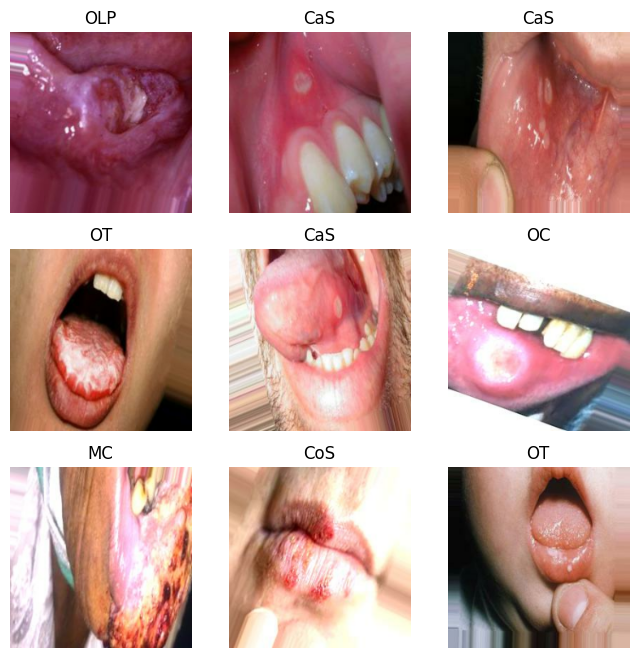

In [10]:
plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [11]:
def count_images(folder):
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        print(cls, ":", len(os.listdir(cls_path)))

print("Training set:")
count_images(os.path.join(DATASET_PATH, "Training"))


Training set:
CaS : 480
CoS : 450
Gum : 360
MC : 540
OC : 324
OLP : 540
OT : 393


**Preprocessing**

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


In [13]:
normalization = layers.Rescaling(1./255)


**Visualization**

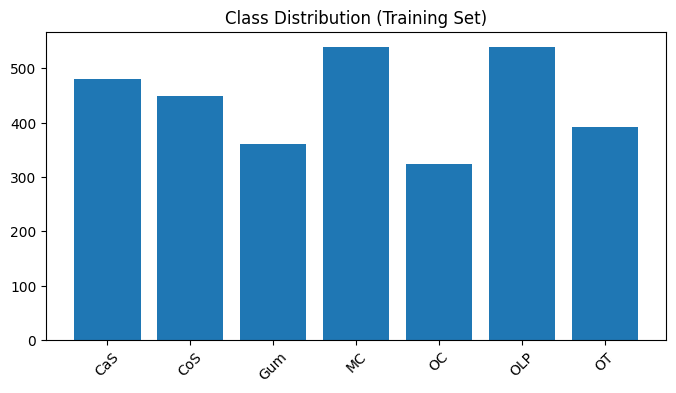

In [10]:
import collections

labels_list = []
for _, labels in train_ds:
    labels_list.extend(labels.numpy())

counter = collections.Counter(labels_list)

plt.figure(figsize=(8,4))
plt.bar(class_names, [counter[i] for i in range(len(class_names))])
plt.title("Class Distribution (Training Set)")
plt.xticks(rotation=45)
plt.show()


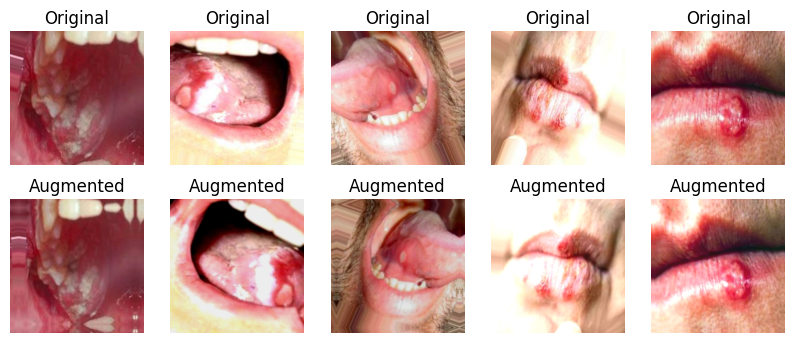

In [11]:
for images, labels in train_ds.take(1):
    augmented_images = data_augmentation(images)

plt.figure(figsize=(10,4))

for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented
    plt.subplot(2,5,i+6)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()


**CNN**

In [22]:
model = models.Sequential([
    layers.Input(shape=(224,224,3)),

    data_augmentation,
    normalization,

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation="softmax")
])


In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [24]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 90s 460ms/step - accuracy: 0.2076 - loss: 1.9228 - val_accuracy: 0.2189 - val_loss: 1.8566
Epoch 2/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 85s 441ms/step - accuracy: 0.2915 - loss: 1.7925 - val_accuracy: 0.3706 - val_loss: 1.6098
Epoch 3/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 84s 435ms/step - accuracy: 0.3628 - loss: 1.6662 - val_accuracy: 0.4504 - val_loss: 1.4874
Epoch 4/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 85s 439ms/step - accuracy: 0.3981 - loss: 1.5806 - val_accuracy: 0.4582 - val_loss: 1.4630
Epoch 5/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.4260 - loss: 1.5002 - val_accuracy: 0.5088 - val_loss: 1.3557
Epoch 6/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.4503 - loss: 1.4374 - val_accuracy: 0.5311 - val_loss: 1.2730
Epoch 7/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 84s 436ms/step - accuracy: 0.4882 - loss: 1.3597 - val_accuracy: 0.5428 - val_loss: 1.1636
Epoch 8/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 418ms/step - accuracy: 0.5177 - loss: 1

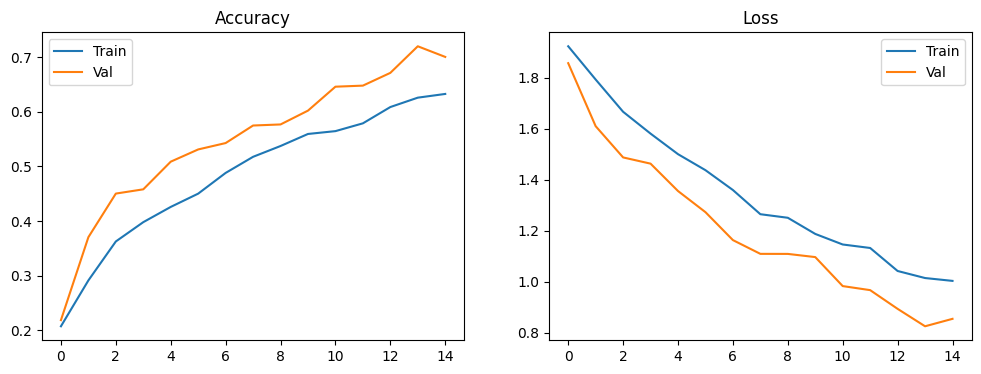

In [26]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()


In [29]:
model.save("dental_classifier.keras")


In [12]:
from tensorflow.keras.models import load_model

model = load_model("dental_classifier.keras")


In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.6887 - loss: 0.8406
Test Accuracy: 0.688715934753418


In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\user\Desktop\teeth classification\Teeth_Dataset\Testing\OT\ot_1200_0_8369.jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)   # add batch dimension

prediction = model.predict(img_array)

predicted_class = class_names[np.argmax(prediction)]

print("Prediction:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: MC


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

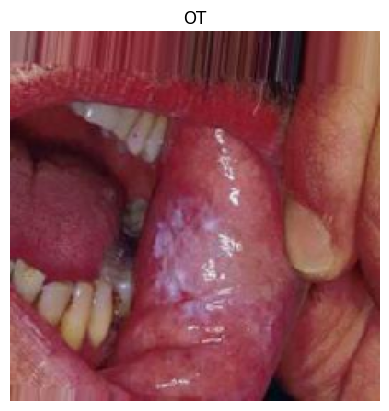

In [18]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(predicted_class)
plt.axis("off")


**EfficientNetB0**

In [14]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)


base_model.trainable = False

model1 = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")
])


In [15]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=3,
    factor=0.3
)


In [28]:
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 113s 550ms/step - accuracy: 0.5128 - loss: 1.4895 - val_accuracy: 0.7724 - val_loss: 0.7497 - learning_rate: 0.0010
Epoch 2/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 100s 520ms/step - accuracy: 0.6832 - loss: 0.8853 - val_accuracy: 0.8298 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 3/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 98s 510ms/step - accuracy: 0.7444 - loss: 0.7282 - val_accuracy: 0.8774 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 4/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 98s 509ms/step - accuracy: 0.7626 - loss: 0.6676 - val_accuracy: 0.9018 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 5/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 97s 503ms/step - accuracy: 0.7975 - loss: 0.5859 - val_accuracy: 0.9280 - val_loss: 0.2207 - learning_rate: 0.0010
Epoch 6/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 97s 506ms/step - accuracy: 0.8141 - loss: 0.5277 - val_accuracy: 0.9163 - val_loss: 0.2370 - learning_rate: 0.0010
Epoch 7/20
193/193 ━━━━━━━━━━━━━━━━━━━━ 102s 531ms/step - accuracy: 

In [29]:
test_loss, test_acc = model1.evaluate(test_ds)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9747 - loss: 0.0699
Test Accuracy: 0.9747081995010376
Test Loss: 0.06988555192947388


In [30]:
model1.save("DentalModel.keras")

In [17]:
from tensorflow.keras.models import load_model

model = load_model("DentalModel.keras")


In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\user\Desktop\teeth classification\Teeth_Dataset\Testing\CaS\a_82_0_9450.jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)   # add batch dimension

prediction = model.predict(img_array)

predicted_class = class_names[np.argmax(prediction)]

print("Prediction:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction: CaS
